In [38]:
import torchvision
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# convolucional 3x3 con batch normalization y relu
def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

# funcion encoder
def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

# clase decoder que recibe la salida de la capa anterior y la salida de la etapa
class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.Sequential(
                        torch.nn.Upsample(scale_factor=2, mode='bicubic'),
                        torch.nn.Conv2d(ci, co, kernel_size=1, stride=1)
                        )
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=4, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(weights='IMAGENET1K_V1')           
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = x.clone().detach()
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
classes = ['rueda', 'gaseosa', 'cuaderno', 'background']
colors = ['#1f77b4', '#ff9e80', '#8bc34a', '#9e9e9e'] # Colores fijos para cada clase

def plot_predict(img, model):
    model.eval().to(device)
    with torch.no_grad():
        img = img.to(device)

        output = model(img)[0]
        pred_mask = torch.argmax(output, dim=0)

    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(30, 10))
    ax1.set_title('Imagen', fontsize=25)
    ax1.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())

    ax3.set_title('Predicción', fontsize=25)
    ax3.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())

    # Asignar colores fijos a cada canal en la pred_mask (one-hot encoding)
    colored_mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
    for i in range(len(classes)):
        colored_mask[pred_mask.cpu() == i] = np.array(mcolors.to_rgba(colors[i], 1)[:3]) * 255  #type: ignore Obtener RGB de los colores fijos y escalar a [0, 255]

    ax3.imshow(colored_mask, alpha=0.8)

    # Crear una leyenda personalizada con colores fijos para cada clase
    legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[i], markersize=10, label=classes[i]) for i in range(len(classes))] # type: ignore

    # Agregar leyenda al tercer subplot
    ax3.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), bbox_transform=ax3.transAxes, fontsize=20)

    plt.show()

In [15]:
# Si no está disponible, cargar el modelo en la CPU directamente
model = UNetResnet()
model.load_state_dict(torch.load('./models/best_UNetResNet.pt', map_location=torch.device('cpu')))
model.eval()

UNetResnet(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [62]:
import random
from PIL import Image
import torchvision.transforms as transforms
# Cargar la imagen desde el archivo
imagen_path = "./5.jpg"
imagen = Image.open(imagen_path)

# Definir la transformación para redimensionar la imagen a 64x64
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Aplicar la transformación a la imagen
imagen_transformada = transform(imagen).unsqueeze(0) # type: ignore
imagen_transformada.shape

torch.Size([1, 3, 512, 512])

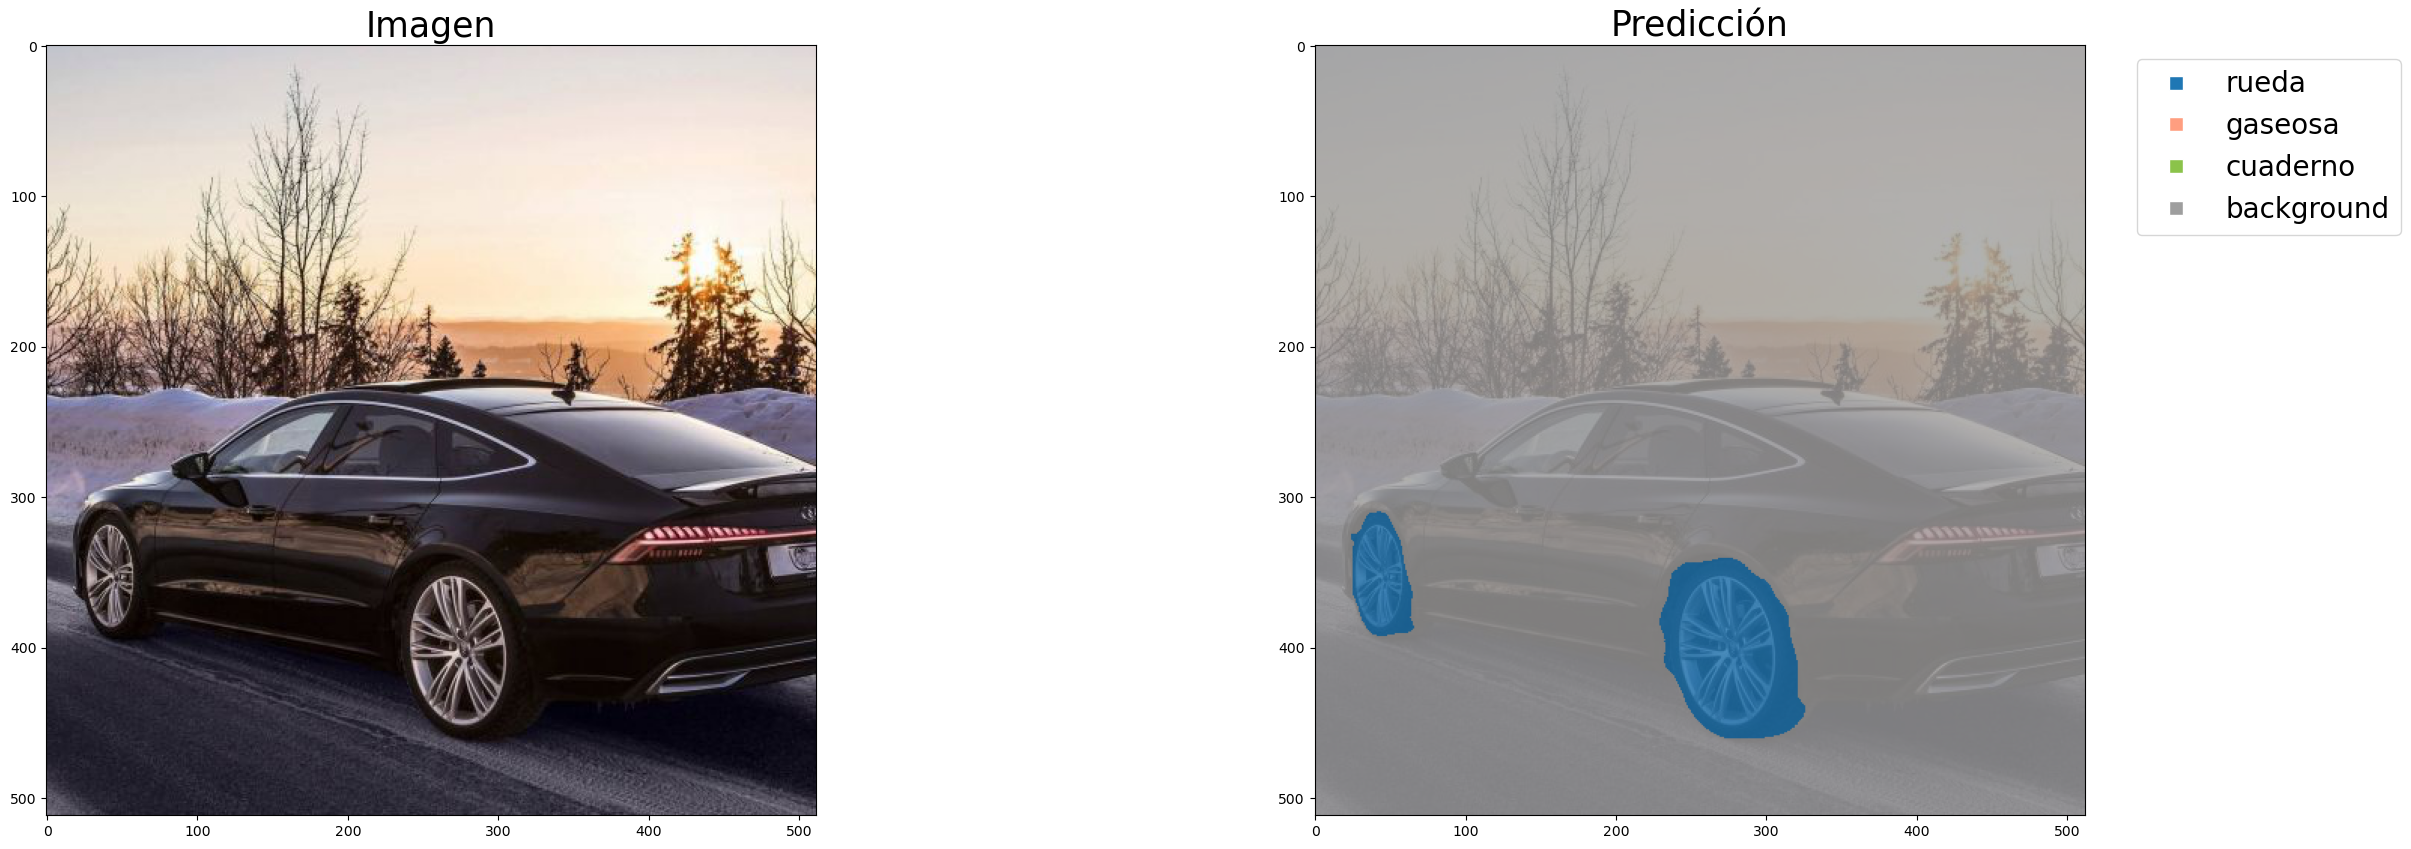

In [63]:
plot_predict(imagen_transformada, model)